In [6]:
%matplotlib inline
from tvb.simulator.lab import *
import os.path
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib import colors, cm
import time
import scipy.signal as sig
import numpy as np

In [7]:
project_dir = "/home/anirudhnihalani/vep.stan/data/CJ"

In [8]:
con = connectivity.Connectivity.from_file(os.path.join(project_dir, "connectivity.zip"))
con.speed = np.inf
# normalize
con.weights = con.weights/np.max(con.weights)
num_regions = len(con.region_labels)

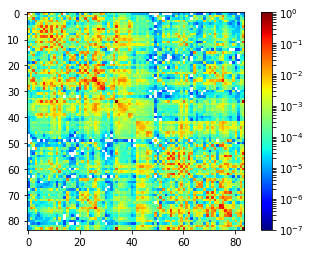

In [10]:
plt.figure()
image = con.weights
norm = mpl.colors.LogNorm(1e-7, image.max()) #, clip='True')
plt.imshow(image, norm=norm, cmap=mpl.cm.jet)
plt.colorbar()
#max(con.weights[con.weights != 0])

In [12]:
epileptors = models.Epileptor(variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'])
epileptors.r = 0.0001
epileptors.Ks = np.ones(num_regions)*(-1.0)*20.0

In [13]:
# Patient specific modifications
ez = [9]
pz = [6, 27]

epileptors.x0 = np.ones(num_regions)*-2.3
epileptors.x0[ez] = -1.8
epileptors.x0[pz] = -2.05

In [14]:
coupl = coupling.Difference(a=1.)

In [16]:
hiss = noise.Additive(nsig = np.array([0.01, 0.01, 0., 0.00015, 0.00015, 0.]))
heunint = integrators.HeunStochastic(dt=0.04, noise=hiss)
heunintdet = integrators.HeunDeterministic(dt=0.04)

In [20]:
! cat /home/anirudhnihalani/vep.stan/data/CJ/seeg.txt

TB'1    -26.63    0.70  -46.78
TB'2    -30.11    0.87  -46.46
TB'3    -33.59    1.05  -46.15
TB'4    -37.07    1.22  -45.84
TB'5    -40.55    1.40  -45.53
TB'6    -44.04    1.58  -45.21
TB'7    -47.52    1.75  -44.90
B'1     -28.71  -18.71  -36.42
B'2     -32.20  -18.48  -36.31
B'3     -35.69  -18.25  -36.20
B'4     -39.18  -18.01  -36.10
B'5     -42.67  -17.78  -35.99
B'6     -46.16  -17.55  -35.88
B'7     -49.65  -17.31  -35.77
B'8     -53.14  -17.08  -35.66
B'9     -56.63  -16.85  -35.55
B'10    -60.12  -16.62  -35.45
B'11    -63.61  -16.38  -35.34
B'12    -67.10  -16.15  -35.23
B'13    -70.60  -15.92  -35.12
B'14    -74.09  -15.69  -35.01
GPH'1   -34.18  -37.27  -22.83
GPH'2   -37.66  -36.90  -22.84
GPH'3   -41.14  -36.53  -22.86
GPH'4   -44.62  -36.16  -22.87
GPH'5   -48.10  -35.79  -22.89
GPH'6   -51.58  -35.42  -22.90
GPH'7   -55.06  -35.06  -22.92
GPH'8   -58.54  -34.69  -22.93
OT'1    -28.84  -51.60  -39.37
OT'2    -32.33  -51.43  -39.09
OT'3    -35.81  -51.25  -38.82
OT'4    

In [22]:
mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=1.0)
mon_SEEG = monitors.iEEG.from_file(sensors_fname=os.path.join(project_dir, "seeg.txt"),
                                   projection_fname=os.path.join(project_dir, "gain_inv-square.txt"),
                                   period=1.0,
                                   variables_of_interest=[6]
                                   )
num_contacts = mon_SEEG.sensors.labels.size

ReaderException: Could not read from /home/anirudhnihalani/.conda/envs/tvb/lib/python2.7/site-packages/tvb_data/regionMapping/regionMapping_16k_76.txt file

In [ ]:
con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources

sim = simulator.Simulator(model=epileptors,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=np.inf,                          
                          integrator=heunint,
                          monitors=[mon_tavg, mon_SEEG])

sim.configure()

In [ ]:
(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=10000)

In [ ]:
# Normalize the time series to have nice plots
tavgn = tavg/(np.max(tavg, 0) - np.min(tavg, 0))
seegn = seeg/(np.max(seeg, 0) - np.min(seeg, 0))
seegn = seegn - np.mean(seegn, 0)

In [ ]:
b, a = sig.butter(2, 0.1, btype='highpass', output='ba')
#seegf = sig.filtfilt(B, A, seegn)
seegf = np.zeros(seegn.shape)
for i in range(num_contacts):
    seegf[:, 0, i, 0] = sig.filtfilt(b, a, seeg[:, 0, i, 0])

In [ ]:

#Plot raw time series
figure(figsize=(9,10))

indf = 0
indt = -1

regf = 0
regt = 84

plot(ttavg[indf:indt], tavg[indf:indt, 6, regf:regt, 0]/4 + np.r_[regf:regt], 'r')
yticks(np.r_[regf:regt], con.region_labels[regf:regt])
title("Epileptors time series")
tight_layout()
show()   

In [ ]:
figure(figsize=(10,20))
plot(tseeg[:], seegn[:, 0, :, 0] + np.r_[:num_contacts])
yticks(np.r_[:num_contacts], mon_SEEG.sensors.labels[:])
title("SEEG")
tight_layout()

In [ ]:
figure(figsize=(10,20))
plot(tseeg[:], (seegn[:, 0, 1:num_contacts, 0] - seegn[:, 0, 0:num_contacts-1, 0]) + np.r_[:num_contacts-1])
yticks(np.r_[:num_contacts], mon_SEEG.sensors.labels[:])
title("SEEG")
tight_layout()

In [ ]:
figure(figsize=(10, 6))

electrodes = [("FCA'", 7), ("GL'", 7), ("CU'", 6), ("PP'", 1),
              ("PI'", 5), ("GC'", 8), ("PFG'", 10),
              ("OT'", 5), ("GPH'", 6), ("PFG", 10)]


for i, (el, num) in enumerate(electrodes):
    ind = np.where(mon_SEEG.sensors.labels == el + str(num))[0][0]
    plot(tseeg[:], (seegn[:, 0, ind, 0] - seegn[:, 0, ind - 1, 0])/0.5 + i)

labels = [el[0] + str(el[1]) + "-" + str(el[1] - 1) for el in electrodes]
yticks(np.r_[:len(electrodes)], labels)
tight_layout()